### Lipidomics mass-spectrometry analysis

This is a hometask on processing lipidomics datasets. 

As an input for it we have several tables with datasets:

- df.csv with data on intensities of aligned MS peaks. Columns are different smples, rows are peaks.
- meta.csv with metadata on samples (e.g. species, place where the sample was tken, etc.)
- mzrt.csv with peaks annotation (mass to charge, retension time).

The datasets are private, so the ones present in the directories are dummies. 

The code below performs data normalization, NAs imputations and control, PCA, T-test and lipids annotation though the last step was completely manual.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading dataset

In [2]:
dataset = pd.read_csv("../hw/df.csv", header=None).T

In [3]:
cols = list(dataset.columns)
cols[0] = 'sample_name'
dataset.columns = cols
dataset = dataset.set_index('sample_name')
dataset.loc[:,:] = np.array(dataset.values, dtype=float)
dataset = dataset.loc[dataset.apply(lambda x: np.logical_not(np.all(np.isnan(x))), axis=1) ,
                      dataset.apply(lambda x: np.logical_not(np.all(np.isnan(x))), axis=0)]

idx         = np.array(list(dataset.index))
cols        = np.array(dataset.columns)

dataset.index = pd.MultiIndex.from_tuples([('raw', x) for x in idx], names=['type', 'sample_index'])

In [4]:
metadata = pd.read_csv("../hw/meta.csv")
cols_meta = list(metadata.columns)
cols_meta[0] = 'sample_name'
metadata.columns = cols_meta
metadata = metadata.set_index('sample_name')

In [5]:
metadata.loc[:, 'group'] = metadata.apply(lambda x: 'human' if x.species=='human' else 'ungulate', axis=1)

### Dataset visualization

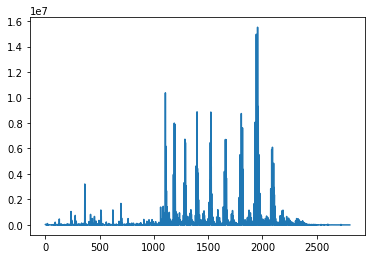

In [6]:
# Plotting the mean values for each peak before log-transformation
plt.plot(np.nanmean( dataset.loc['raw', :, :].values, axis=0 ))

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


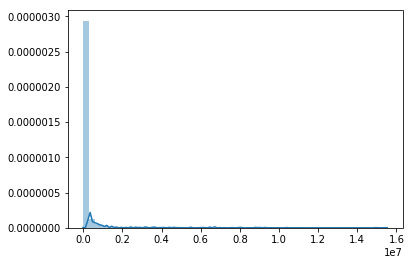

In [7]:
# Plotting distribution of values
toplot = np.nanmean( dataset.loc['raw', :, :].values, axis=0 )
sns.distplot( toplot[np.isfinite(toplot)] )

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


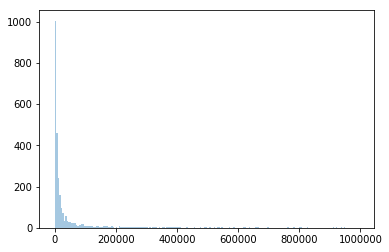

In [8]:
sns.distplot( toplot[np.isfinite(toplot)], bins=np.arange(0, 1e6, 5e3), kde=False )

### Dataset log-transformation

In [10]:
# log-transformation. Note the usage of multiindex, which allows for the nice storage of data at all the steps
dataset = pd.concat( [dataset, 
            pd.DataFrame( np.log(dataset.loc['raw', idx, :].values), 
             index   = pd.MultiIndex.from_tuples([('log', x) for x in idx], names=['type', 'sample_index']),
             columns = cols)
           ])

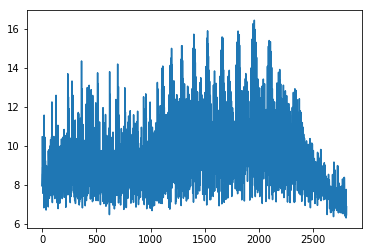

In [10]:
# Let's see how the data is transformed. No peaks anymore!
plt.plot(np.nanmean( dataset.loc['log', :, :].values, axis=0 ))

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


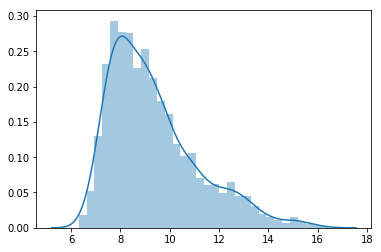

In [11]:
# And the distribution is close to normal
sns.distplot( np.nanmean( dataset.loc['log', :, :].values, axis=0 ) )

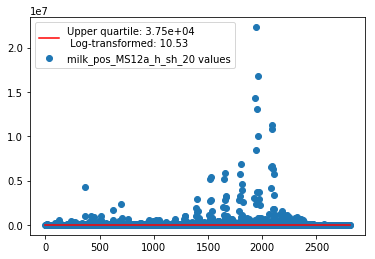

In [12]:
# Let's see the effect for a sinle sample

k = 'milk_pos_MS12a_h_sh_20'
toplot = dataset.loc['raw', k, :].values[0]
plt.scatter(np.arange(len(toplot)), toplot, label='{} values'.format(k))
upper_quart = np.nanpercentile(toplot, 75)
plt.plot([0, len(toplot)], [upper_quart, upper_quart], color='red', 
         label='Upper quartile: {:.2e}\n Log-transformed: {:.2f}'.format(upper_quart, np.log(upper_quart)))
plt.legend()

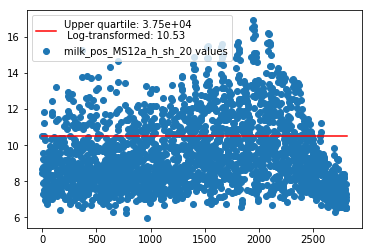

In [13]:
k = 'milk_pos_MS12a_h_sh_20'
toplot = dataset.loc['log', k, :].values[0]
plt.scatter(np.arange(len(toplot)), toplot, label='{} values'.format(k))
upper_quart = np.nanpercentile(toplot, 75)
plt.plot([0, len(toplot)], [upper_quart, upper_quart], color='red', 
         label='Upper quartile: {:.2e}\n Log-transformed: {:.2f}'.format(np.exp(upper_quart), upper_quart))
plt.legend()

### NA quality control

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


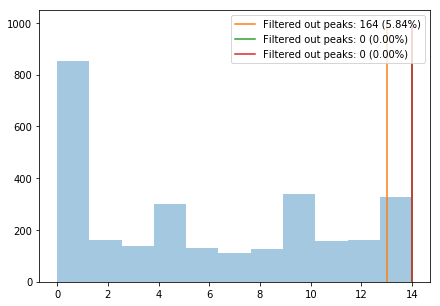

In [14]:
# Let's calculate the number of NAs per peak

plt.figure(figsize=[7,5])

count_nan_per_peak = np.sum( np.isnan(dataset.loc['log', :, :].values ), axis=0)
sns.distplot(count_nan_per_peak, kde=False )
for score in [90, 95, 99]:
    toplot = np.percentile(count_nan_per_peak, score)
    plt.plot([toplot, toplot], [0,1000], 
             label="Filtered out peaks: {} ({:.2f}%)".format(
                 np.sum(count_nan_per_peak>toplot), 100*np.sum(count_nan_per_peak>toplot)/len(count_nan_per_peak)))
    
plt.legend(loc='upper right')

In [15]:
th_na_per_peak = np.percentile(count_nan_per_peak, 90)
cols_NAFilterFailed = cols[count_nan_per_peak>th_na_per_peak]

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


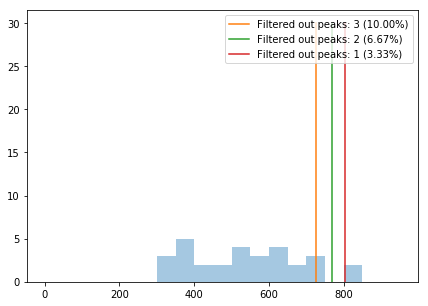

In [16]:
# Number of NAs per sample

count_nan_per_sample = np.sum( np.isnan(dataset.loc['log', :, :].values ), axis=1)

plt.figure(figsize=[7,5])

sns.distplot(count_nan_per_sample, kde=False, bins=np.arange(0,1000,50) )
for score in [90, 95, 99]:
    toplot = np.percentile(count_nan_per_sample, score)
    plt.plot([toplot, toplot], [0,30], 
             label="Filtered out peaks: {} ({:.2f}%)".format(
                 np.sum(count_nan_per_sample>toplot), 100*np.sum(count_nan_per_sample>toplot)/len(count_nan_per_sample)))
    
plt.legend(loc='upper right')

In [17]:
th_na_per_sample = np.percentile(count_nan_per_sample, 99)
idx_NAFilterFailed = idx[count_nan_per_sample>th_na_per_sample]

### Sample outliers detection

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


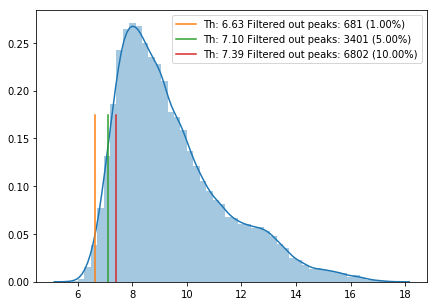

In [22]:
# Let's check whether we have some samples-outliers

total = dataset.loc['log', :, :].values.flatten()
total = total[np.isfinite(total)]
plt.figure(figsize=[7,5])
sns.distplot(total)

for score in [1, 5, 10]:
    toplot = np.percentile(total, score)
    plt.plot([toplot, toplot], [0,0.175], 
             label="Th: {:.2f} Filtered out peaks: {} ({:.2f}%)".format(
                 toplot, np.sum(total<toplot), 100*np.sum(total<toplot)/len(total)))
    
plt.legend(loc='upper right')

In [23]:
toplot = dataset.loc['log', :, :].T.reset_index()#.T

In [24]:
tmp = []
for x in idx:
    df_tmp = toplot.loc[:,['index', x]].copy()
    df_tmp.columns = ['index', 'value']
    df_tmp.loc[:,'sample'] = x
    tmp.append(df_tmp.copy())
tmp = pd.concat( tmp )

In [25]:
#Let's calculate how many peaks per sample are less than total 5% percentile and sort samples by this value
vals = dataset.loc['log', :, :].apply(lambda x: np.sum(x<7.1), axis=1)
vals_sorted = vals.sort_values(ascending=False)

In [26]:
(dataset.loc['log', :, :]).shape

(30, 2807)

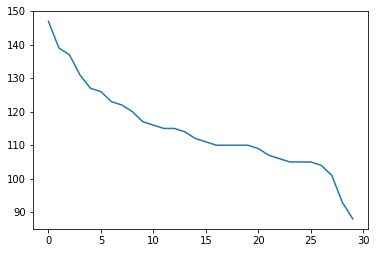

In [27]:
plt.plot( vals_sorted.values )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

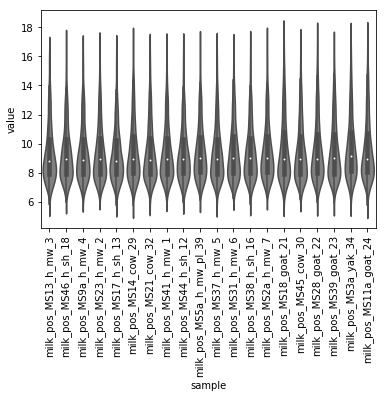

In [28]:
# The difference between "worst" and the "best" samples is not noticable
sns.violinplot(x="sample", y="value", data=tmp, order=np.concatenate([vals_sorted.index[0:10], 
                                                                      vals_sorted.index[-10:]]), color='grey')
plt.xticks(rotation=90)

In [29]:
### Yay! No need to filter out bad samples! They are all pretty good.

### Final filtering out and stats

Let's plot the filtering steps to learn how bad are the data. We're not going to use these filters, because the hometask doesn't require this. So this step is just for our information.

In [33]:
# All filters present are:
#idx_NAFilterFailed, cols_NAFilterFailed

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


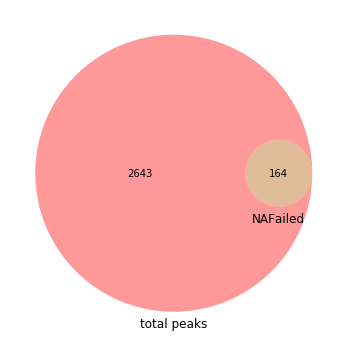

In [34]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

v1 = cols
v2 = cols_NAFilterFailed
cols_ContaminationFilterFailed = np.array([])
v3 = cols_ContaminationFilterFailed

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=['total peaks', 'NAFailed', ''])
plt.show()


/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


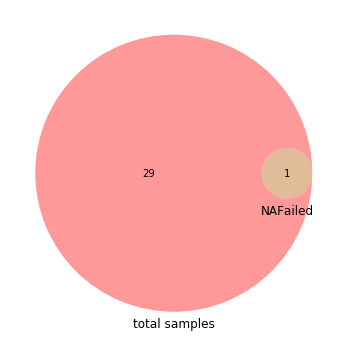

In [35]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

v1 = idx
v2 = idx_NAFilterFailed
v3 = cols_ContaminationFilterFailed

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=['total samples', 'NAFailed', ''])
plt.show()


In [36]:
cols_good = np.setdiff1d( np.setdiff1d(cols,  cols_ContaminationFilterFailed), cols_NAFilterFailed )
idx_good  = np.setdiff1d( idx,  idx_NAFilterFailed)

### Upper-quartile normalization

This step is required to make samples comparale between each other. 
We're normalizing signal for each sample by normalizing by 75%-quantile.

In [37]:
norm_coef = np.nanmean(np.nanpercentile(dataset.loc['log', :, :].values, 75, axis=1))

dataset = pd.concat( [dataset, 
            pd.DataFrame( norm_coef*dataset.loc['log', :, :].apply(
                lambda x: x/np.nanpercentile(x.values, 75), axis=1).values, 
             index   = pd.MultiIndex.from_tuples([('norm', x) for x in idx], names=['type', 'sample_index']),
             columns = cols)
           ])

Text(0.5,1,'Upper-quartile per sample')

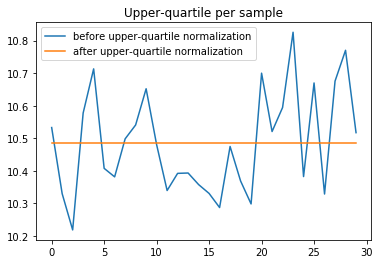

In [38]:
plt.plot(np.nanpercentile( dataset.loc['log', :, :], 75, axis=1), label="before upper-quartile normalization" )
plt.plot(np.nanpercentile( dataset.loc['norm', :, :], 75, axis=1), label="after upper-quartile normalization" )
plt.legend()
plt.title("Upper-quartile per sample")

Text(0.5,1,'Mean per sample')

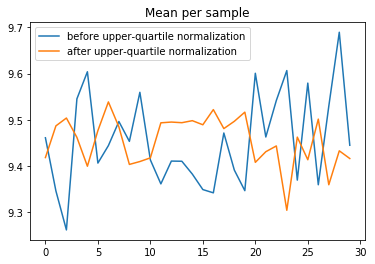

In [39]:
plt.plot(np.nanmean( dataset.loc['log', :, :], axis=1), label="before upper-quartile normalization" )
plt.plot(np.nanmean( dataset.loc['norm', :, :], axis=1),       label="after upper-quartile normalization" )
plt.legend()
plt.title("Mean per sample")

### NA imputation

There are many imaginable ways to perform NAs imputation, e.g.:
- fillig with 0
- filling with total minimum
- filling with total mean
- filling with per sample mean
- filling with per sample min

In [40]:
df_tmp = dataset.loc['norm', :, :].apply(lambda x: x.fillna( np.nanmin(x) ), axis=1)

df_tmp = pd.DataFrame( df_tmp.values, 
         index   = pd.MultiIndex.from_tuples([('norm_na2minPerSample', x) for x in idx], 
                                             names=['type', 'sample_index']),
         columns = cols)

dataset = pd.concat( [dataset, df_tmp])

In [41]:
df_tmp = dataset.loc['norm', :, :].apply(lambda x: x.fillna( np.nanmean(x) ), axis=1)

df_tmp = pd.DataFrame( df_tmp.values, 
         index   = pd.MultiIndex.from_tuples([('norm_na2meanPerSample', x) for x in idx], 
                                             names=['type', 'sample_index']),
         columns = cols)

dataset = pd.concat( [dataset, df_tmp])

In [42]:
df_tmp = dataset.loc['norm', :, :].apply(lambda x: x.fillna( 0 ), axis=1)

df_tmp = pd.DataFrame( df_tmp.values, 
         index   = pd.MultiIndex.from_tuples([('norm_na2zeros', x) for x in idx], 
                                             names=['type', 'sample_index']),
         columns = cols)

dataset = pd.concat( [dataset, df_tmp])

In [43]:
mn = np.nanmin(dataset.loc['norm', :, :])
df_tmp = dataset.loc['norm', :, :].apply(lambda x: x.fillna( mn ), axis=1)

df_tmp = pd.DataFrame( df_tmp.values, 
         index   = pd.MultiIndex.from_tuples([('norm_na2minTotal', x) for x in idx], 
                                             names=['type', 'sample_index']),
         columns = cols)

dataset = pd.concat( [dataset, df_tmp])

In [44]:
mn = np.nanmean(dataset.loc['norm', :, :])
df_tmp = dataset.loc['norm', :, :].apply(lambda x: x.fillna( mn ), axis=1)

df_tmp = pd.DataFrame( df_tmp.values, 
         index   = pd.MultiIndex.from_tuples([('norm_na2meanTotal', x) for x in idx], 
                                             names=['type', 'sample_index']),
         columns = cols)

dataset = pd.concat( [dataset, df_tmp])

### PCA

Let's do some PCA with one of the imputation methods. I personally like filling with sample mean the most, so let's try it first. 

In [45]:
from sklearn.decomposition import PCA

In [46]:
norm_type = 'norm_na2minPerSample'

In [47]:
toplot = dataset.loc[norm_type, :, :]

n_comp = 10

pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(toplot)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['pc{}'.format(x+1) for x in range(n_comp)],
                          index = toplot.index)

finalDf = principalDf.reset_index().join(metadata.reset_index())

Text(0.5,1,'Variance explained: norm_na2minPerSample')

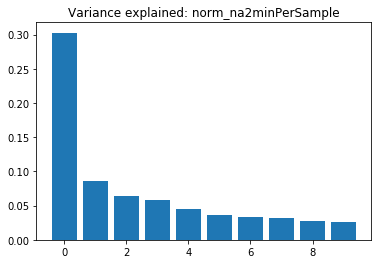

In [49]:
# Variance explained by 1st component is not very bad:
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
plt.title('Variance explained: {}'.format(norm_type))

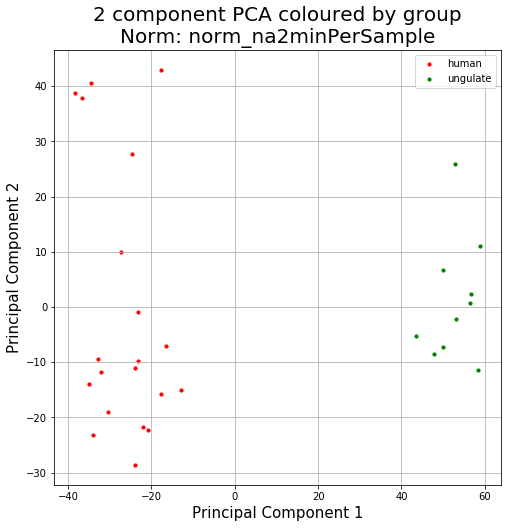

In [51]:
# Amazing clusterization by group of species!

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by group\nNorm: {}'.format(norm_type), fontsize = 20)
targets = np.unique( finalDf.group )
colors = ['r', 'g',]
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['group'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

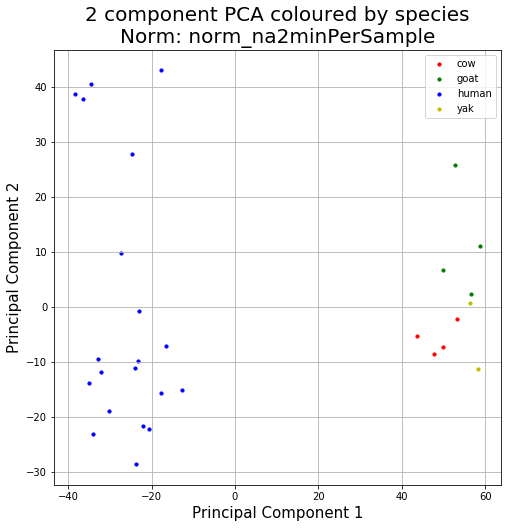

In [52]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by species\nNorm: {}'.format(norm_type), fontsize = 20)
targets = np.unique( finalDf.species )
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['species'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

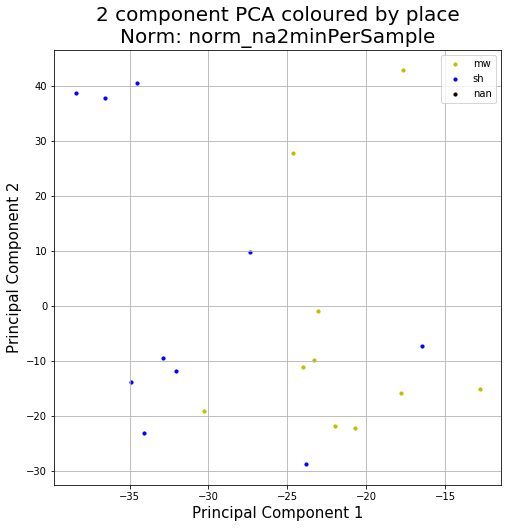

In [53]:
# not so amazing, but still some clusterisation by place is also visible
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by place\nNorm: {}'.format(norm_type), fontsize = 20)
targets = ['mw', 'sh', np.nan]
colors = ['y', 'b', 'black']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['place'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

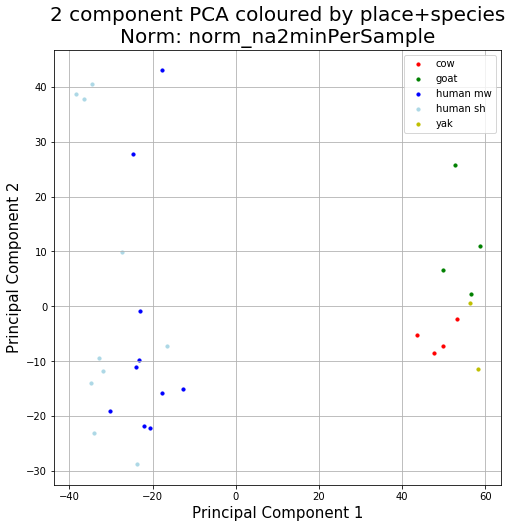

In [54]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by place+species\nNorm: {}'.format(norm_type), fontsize = 20)
targets = np.unique(finalDf['species h'].values)
colors = ['r', 'g', 'b', 'lightblue', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['species h'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

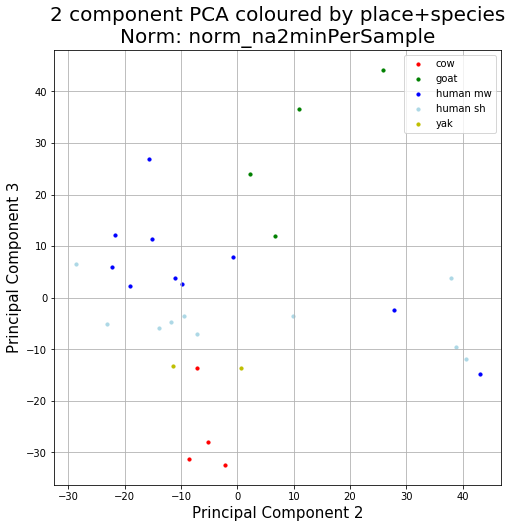

In [55]:
# 2nd vs 3rd components is not so informative
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA coloured by place+species\nNorm: {}'.format(norm_type), fontsize = 20)
targets = np.unique(finalDf['species h'].values)
colors = ['r', 'g', 'b', 'lightblue', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['species h'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc2'], finalDf.loc[indicesToKeep, 'pc3'], c = color, s = 10)
ax.legend(targets)
ax.grid()

### T-test

Now we would like to know what lipids are different between human and ungulates.

For this we are going to infer T-tast with bonferroni correction. 

In [56]:
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

In [57]:
df = dataset.loc[norm_type, :, :].reset_index().join(metadata.reset_index())

In [58]:
v1 = (df['group']=='human')
v2 = (df['group']=='ungulate')

In [59]:
df.loc['pv', cols] = df.loc[:, cols].apply(lambda x: scipy.stats.ttest_ind(x.loc[v1], x.loc[v2], equal_var = False)[1], axis=0)
p_adjusted = multipletests(df.loc['pv', cols], method='bonferroni')
df.loc['pv_adj', cols] = p_adjusted[1]

Text(0.5,1,'#pv<0.05: 489\n#pv<0.01: 434')

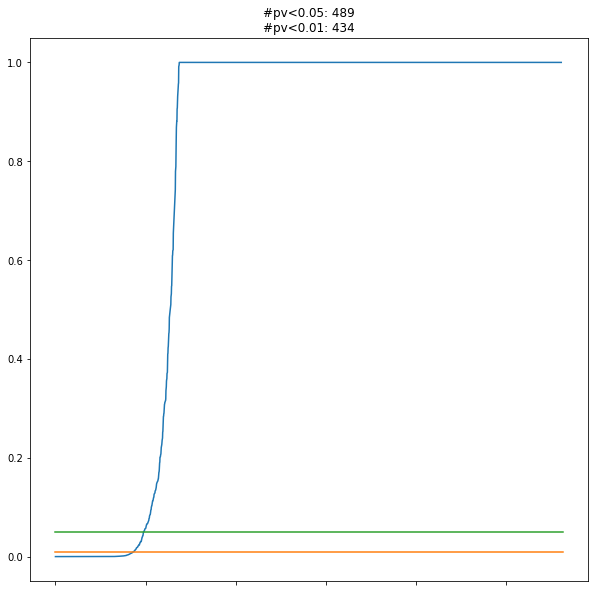

In [60]:
toplot = df.sort_values('pv_adj', axis=1).loc['pv_adj',:]
plt.figure(figsize=[10,10])
toplot.plot()
plt.plot([0,len(toplot)], [0.01, 0.01])
plt.plot([0,len(toplot)], [0.05, 0.05])
plt.title("#pv<0.05: {}\n#pv<0.01: {}".format(np.sum(toplot<0.05), np.sum(toplot<0.01)))

In [61]:
#v Final list of differential peaks:
list_diff_lipids = np.array(toplot.index[(toplot<0.01)].values, dtype=int)

### Results robustness to NA imputation method

Let's repeat PCA and differential analysis for all the methods. Results are pretty robust, but still some variation is visible:

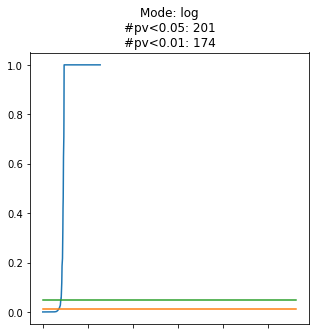

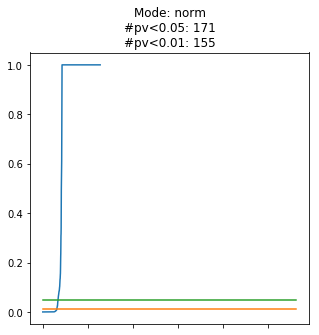

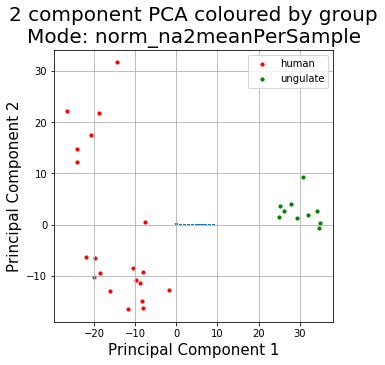

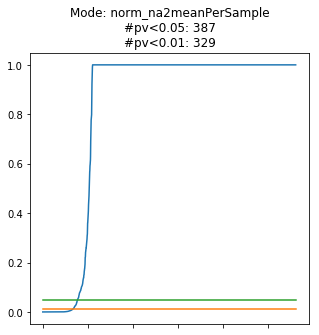

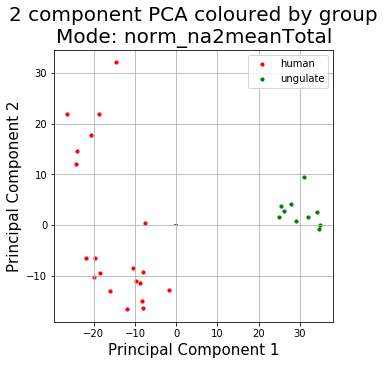

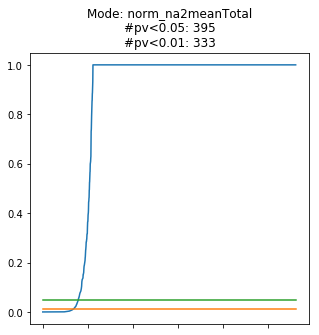

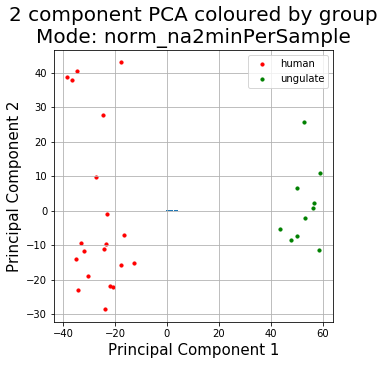

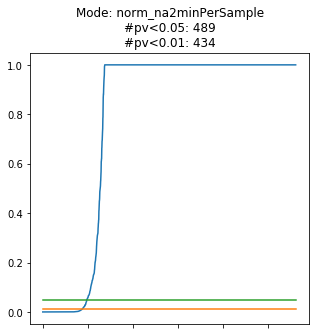

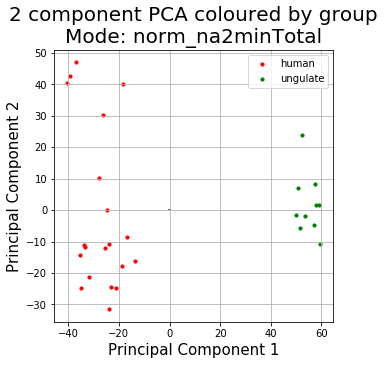

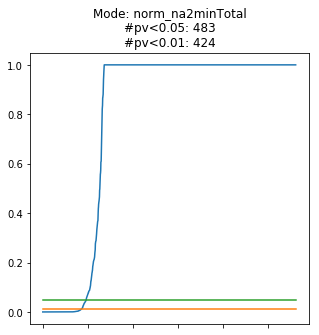

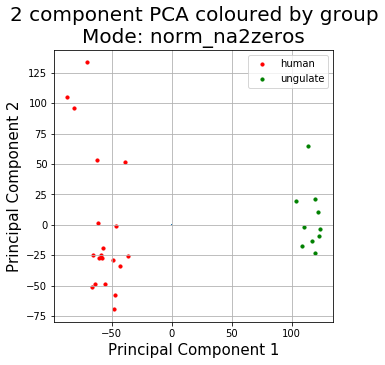

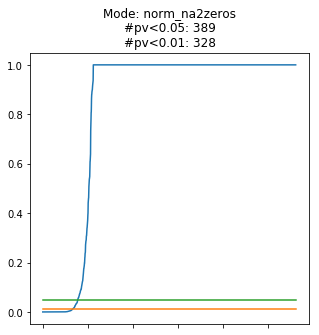

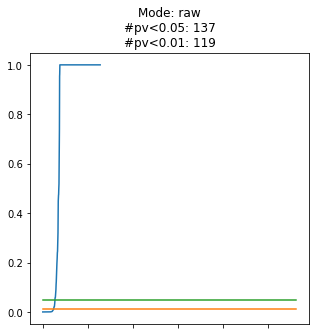

In [63]:
diff_lipids = {}

for norm_type in dataset.index.levels[0]:
    
    toplot = dataset.loc[norm_type, :, :]

    n_comp = 10

    try:
        pca = PCA(n_components=n_comp)
        principalComponents = pca.fit_transform(toplot)

        principalDf = pd.DataFrame(data = principalComponents, 
                                   columns = ['pc{}'.format(x+1) for x in range(n_comp)],
                                  index = toplot.index)

        finalDf = principalDf.reset_index().join(metadata.reset_index())

        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot(1,1,1) 
        plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
        plt.title('Variance explained: {}'.format(norm_type))

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('2 component PCA coloured by group\nMode: {}'.format(norm_type), fontsize = 20)
        targets = np.unique( finalDf.group )
        colors = ['r', 'g',]
        for target, color in zip(targets, colors):
            indicesToKeep = finalDf['group'] == target
            ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
        ax.legend(targets)
        ax.grid()
    
    except Exception as e:
        pass
    
    df = dataset.loc[norm_type, :, :].reset_index().join(metadata.reset_index())
    
    v1 = (df['group']=='human')
    v2 = (df['group']=='ungulate')

    df.loc['pv', cols] = df.loc[:, cols].apply(lambda x: scipy.stats.ttest_ind(x.loc[v1], x.loc[v2], equal_var = False)[1], axis=0)
    p_adjusted = multipletests(df.loc['pv', cols], method='bonferroni')
    df.loc['pv_adj', cols] = p_adjusted[1]

    toplot = df.sort_values('pv_adj', axis=1).loc['pv_adj',:]
    plt.figure(figsize=[5,5])
    toplot.plot()
    plt.plot([0,len(toplot)], [0.01, 0.01])
    plt.plot([0,len(toplot)], [0.05, 0.05])
    plt.title("Mode: {}\n#pv<0.05: {}\n#pv<0.01: {}".format(norm_type, np.sum(toplot<0.05), np.sum(toplot<0.01)))
    
    list_diff_lipids = np.array(toplot.index[(toplot<0.01)].values, dtype=int)
    
    diff_lipids[norm_type] = list_diff_lipids.copy()

Let's calculate overlap between different methods: 

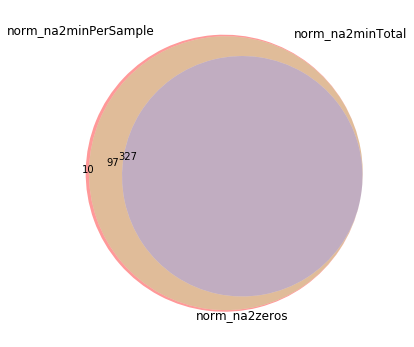

In [64]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

k1, k2, k3 = ['norm_na2minPerSample', 'norm_na2minTotal', 'norm_na2zeros']
v1 = diff_lipids[k1]
v2 = diff_lipids[k2]
v3 = diff_lipids[k3]

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=[k1, k2,k3])
plt.show()

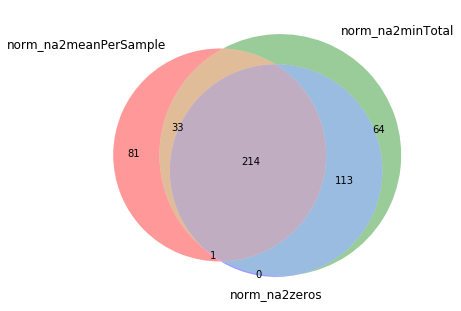

In [65]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

k1, k2, k3 = ['norm_na2meanPerSample', 'norm_na2minTotal', 'norm_na2zeros']
v1 = diff_lipids[k1]
v2 = diff_lipids[k2]
v3 = diff_lipids[k3]

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=[k1, k2,k3])
plt.show()

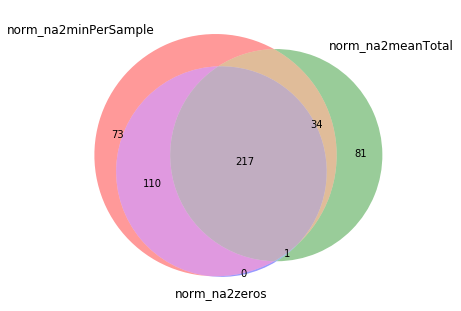

In [66]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

k1, k2, k3 = ['norm_na2minPerSample', 'norm_na2meanTotal', 'norm_na2zeros']
v1 = diff_lipids[k1]
v2 = diff_lipids[k2]
v3 = diff_lipids[k3]

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=[k1, k2,k3])
plt.show()

The best way is seemingly imputation with min per sample. So let's stick to it and try to annotate.

### Lipids annotation

In [87]:
final_list = diff_lipids['norm_na2minPerSample'][0:5]

In [102]:
lipids_annotation = pd.read_csv('../hw_real/mzrt.csv')
lipids_annotation.columns = ['number'] + list(lipids_annotation.columns)[1:]
lipids_annotation['number'] = lipids_annotation['number'].astype(int)-1
lipids_annotation = lipids_annotation.set_index('number')

In [103]:
lipids_annotation.loc[final_list,:]

,mz,rt(min)
number,,
1626,813.766375,11.947525
1896,865.772597,11.704633
1761,840.776135,11.863817
1875,862.758738,11.575067
580,495.441843,10.978175


In [104]:
for x in [str(x) for x in lipids_annotation.loc[final_list,'mz']]:
    print(x)

813.766375236375
865.77259743501
840.776135157632
862.758738149612
495.441843162928


We're submitting this result to the database: http://www.lipidmaps.org/tools/index.html, tool: http://www.lipidmaps.org/tools/ms/lm_bulk_search.php

Screenshot of submission: 
![Resulting image](../hw/sub_hw.png)

In [107]:
result = pd.read_csv('../hw/mshits_hw.txt', sep='\t')

In [108]:
result

,Input Mass,Matched Mass,Delta,Name,Formula,Ion
865.772597,865.7796,0.0070,CE(34:6),C61H101O2,[M+H]+,NaN
865.772597,865.7643,0.0083,DG(54:6),C57H101O5,[M+H]+,NaN
865.772597,865.7643,0.0083,TG(O-54:6),C57H101O5,[M+H]+,NaN
865.772597,865.7643,0.0083,TG(P-54:5),C57H101O5,[M+H]+,NaN
840.776135,840.7803,0.0042,DG(O-52:6),C55H102NO4,[M+NH4]+,NaN
840.776135,840.7803,0.0042,DG(P-52:5),C55H102NO4,[M+NH4]+,NaN
862.758738,862.7623,0.0036,PA(O-47:0),C50H105NO7P,[M+NH4]+,NaN
495.441843,495.4408,0.0011,MG(28:2),C31H59O4,[M+H]+,NaN
495.441843,495.4460,0.0042,DG(59:1),C62H120O5Na2,[M+2Na]2+,NaN
495.441843,495.4460,0.0042,TG(O-59:1),C62H120O5Na2,[M+2Na]2+,NaN


Resulting output:
![Resulting image](../hw/pic_hw.png)

### Conclusion

We performed the last steps of lipidomics MS analysis and selected the list of top differential lipids between ungulates and human. There is some ambiguity in database output, because for nearly the same mass several lipids can be found.

### Bonus tasks. Making sense of retension times.

(300, 1050)

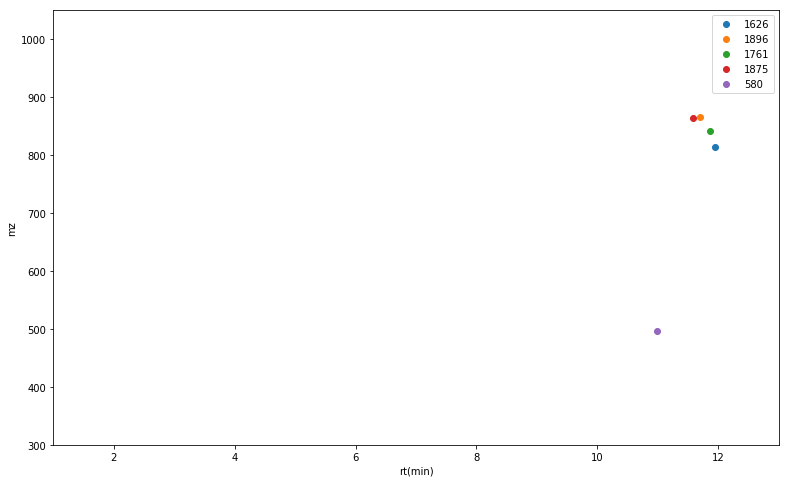

In [132]:
plt.figure(figsize=[13,8])
toplot = lipids_annotation.loc[final_list,:]
for i,r, in toplot.iterrows():
    plt.scatter(r['rt(min)'], r['mz'], label=i)
plt.ylabel('mz')
plt.xlabel('rt(min)')
plt.legend()
plt.xlim([1, 13])
plt.ylim([300, 1050])

Let's match with given database of m/z and rt values:

![Database](../hw/database_hw.png)

In [110]:
result

,Input Mass,Matched Mass,Delta,Name,Formula,Ion
865.772597,865.7796,0.0070,CE(34:6),C61H101O2,[M+H]+,NaN
865.772597,865.7643,0.0083,DG(54:6),C57H101O5,[M+H]+,NaN
865.772597,865.7643,0.0083,TG(O-54:6),C57H101O5,[M+H]+,NaN
865.772597,865.7643,0.0083,TG(P-54:5),C57H101O5,[M+H]+,NaN
840.776135,840.7803,0.0042,DG(O-52:6),C55H102NO4,[M+NH4]+,NaN
840.776135,840.7803,0.0042,DG(P-52:5),C55H102NO4,[M+NH4]+,NaN
862.758738,862.7623,0.0036,PA(O-47:0),C50H105NO7P,[M+NH4]+,NaN
495.441843,495.4408,0.0011,MG(28:2),C31H59O4,[M+H]+,NaN
495.441843,495.4460,0.0042,DG(59:1),C62H120O5Na2,[M+2Na]2+,NaN
495.441843,495.4460,0.0042,TG(O-59:1),C62H120O5Na2,[M+2Na]2+,NaN


Comparison of plot implies that peaks 1626, 1896, 1761, 1875 are probably TAG/TG type (triglyceride).

Peak 580 is probably DAG/DG (diglyceride). Thus we can reduce the ambiguity of our output to: 

In [134]:
result.loc['peak_number'] = []
result.iloc[[2,3,4,5,5,8],:]

,Input Mass,Matched Mass,Delta,Name,Formula,Ion
865.772597,865.7643,0.0083,TG(O-54:6),C57H101O5,[M+H]+,NaN
865.772597,865.7643,0.0083,TG(P-54:5),C57H101O5,[M+H]+,NaN
840.776135,840.7803,0.0042,DG(O-52:6),C55H102NO4,[M+NH4]+,NaN
840.776135,840.7803,0.0042,DG(P-52:5),C55H102NO4,[M+NH4]+,NaN
840.776135,840.7803,0.0042,DG(P-52:5),C55H102NO4,[M+NH4]+,NaN
495.441843,495.4460,0.0042,DG(59:1),C62H120O5Na2,[M+2Na]2+,NaN
